In [66]:
# Python
from datetime import datetime
import time
# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy        as np
import numpy.random as random
from numpy import cos, exp, log, pi, sin, sqrt, arcsinh, sinh
from random import randrange

## Onsager's Solution and Critical Temperature
### Introduction
For this project, we'll be numerically solving for the absolute magnetization per spin, so, for reference, we'll be plotting the analytical solution for the absolute magnetization per spin, which Onsager has solved for a 2D square lattice. Magnetization is just the quantity that determines the magnetic capabilities of a system.
$$m = \left[1-\left(\sinh\left(\frac{2J}{kT}\right)\right)^{-4}\right]^{\frac{1}{8}}$$
There's an interesting thing that occurs at the critical temperature, which is the lowest temperature at which $m=0$.
$$\sinh\left(\frac{2J}{kT_c}\right)=1 \rightarrow \frac{2J}{kT_c} = \sinh^{-1}(1) \rightarrow kT_c=\frac{2J}{\sinh^{-1}(1)}$$
Any temperature higher than $kT_c$ should have a magnetization of 0.

<ipython-input-70-1b06373d65d5>:6: RuntimeWarning: divide by zero encountered in true_divide
  mplt1_1 = (1 - (sinh((2*J)/kT1_1))**(-4))**(1/8)
<ipython-input-70-1b06373d65d5>:6: RuntimeWarning: invalid value encountered in power
  mplt1_1 = (1 - (sinh((2*J)/kT1_1))**(-4))**(1/8)


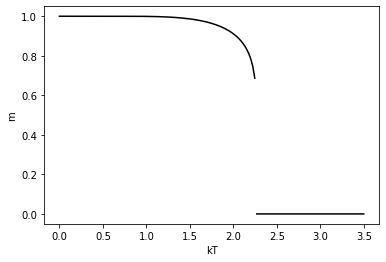

In [70]:
J = 1
kTc = (2*J)/arcsinh(1)
kT1_1 = np.linspace(0,kTc,100)
kT1_2 = np.linspace(kTc,3.5,100)
kT1 = np.concatenate([kT1_1,kT1_2])
mplt1_1 = (1 - (sinh((2*J)/kT1_1))**(-4))**(1/8)
mplt1_2 = kT1_2-kT1_2
mplt1 = np.concatenate([mplt1_1,mplt1_2])

plt.plot(kT1,mplt1,'k-')
plt.xlabel('kT')
plt.ylabel('m')
plt.show()

**Figure 1:** This is the analytical plot of the absolute magnetization per spin. We see that the $m\rightarrow 0$ as $kT\rightarrow kT_c$.

## Two-Dimensional Model: No External Magnetic Field
### Introduction
We'll be studying the 2D Ising Model with no external magnetic field, using the Metropolis Algorithm. Additionally, we'll plotting the evolution of the lattices, seeing how the energy and magnetization changes over time. We will do this for multiple temperatures and find the relationship between the average absolute magnetization and energy per spin & temperature. In magnetic material, the spins or dipoles would flip their spins to align their spins, as it is the most energetically favorable. We would simulate this; in addition, we will analytically calculate the change of energy when one of the spins flips.
$$E_{i,\text{old}}=-J\sum_{j}s_is_j$$
$$E_{i,\text{new}}=-J\sum_{j}(-s_i)s_j = J\sum_{j}s_is_j$$
$$\Delta E_i=2Js_i\left(s_{j_1}+s_{j_2}+s_{j_3}+s_{j_4}\right)$$
Analytically calculating helps speed up calculations, without calling the isingE2(grid,J) function to compute the energy for the new state, by just doing $E_{\text{new}} = E_{\text{old}} + \Delta E$ (if the state is accepted in the algorithm). 

In [7]:
def isingE2(grid,J):
    rows = len(grid[:,0])
    cols = len(grid[0,:])
    E = 0
    for j1 in range(cols):
        for i1 in range(rows):
            if (i1 >= rows-1): i2 = 0
            else: i2 = i1+1
            j2 = j1
            E += (grid[i1,j1]*grid[i2,j2])
    for i1 in range(rows):
        for j1 in range(cols):
            if (j1 >= cols-1): j2 = 0
            else: j2 = j1+1
            i2 = i1
            E += (grid[i1,j1]*grid[i2,j2])
    E *= -J/4 # double double counting
    return E

def mcsIsingModel(grid,steps,J,kT):
    L = len(grid)
    N = L*L
    oldGrid = np.copy(grid)
    tm = np.absolute(np.sum(oldGrid)) # total magnetization, m
    oldE = isingE2(oldGrid,J)
    Es = np.zeros(steps)
    Esqs = np.zeros(steps)
    tms = np.zeros(steps) #total magnetization for each MCS
    tmsqs = np.zeros(steps)
    grids = []
    Es[0] = oldE
    Esqs[0] = oldE*oldE
    tms[0] = tm
    tmsqs[0] = tm*tm
    grids.append(oldGrid)
    

    for k in range(1, steps):
        # Calculating adjacent spin locations for left, right, top, and bottom spins, respectively
        for spin in range(N):
            i1 = randrange(L)  # choose a row number
            j1 = randrange(L)  # choose a column number
            if (i1 >= L-1): i2,i3,i4,i5 = i1,i1,i1-1,0
            elif (i1 < 1): i2,i3,i4,i5 = i1,i1,L-1,i1+1
            else: i2,i3,i4,i5 = i1,i1,i1-1,i1+1
            if (j1 >= L-1): j2,j3,j4,j5 = j1-1,0,j1,j1
            elif (j1 < 1): j2,j3,j4,j5 = L-1,j1+1,j1,j1
            else: j2,j3,j4,j5 = j1-1,j1+1,j1,j1

            s1,s2,s3,s4,s5 = oldGrid[i1,j1],oldGrid[i2,j2],oldGrid[i3,j3],oldGrid[i4,j4],oldGrid[i5,j5]

            dE = 2*J*s1*(s2 + s3 + s4 + s5)

            p = exp(-dE/(kT))
            if (random.rand() < p):
                oldGrid[i1,j1] = -s1
                oldE = oldE + dE
                tm = np.absolute(np.sum(oldGrid))

            if k == steps//2 or k == steps-1:
                grids.append(oldGrid)

        Es[k] = oldE
        Esqs[k] = oldE*oldE
        tms[k] = tm
        tmsqs[k] = tm*tm
    
    tms /= N # Absolute magnetization per spin over time
    Es /= N # Energy per spin over time
    
    return tms,Es,tmsqs,Esqs,grids

In [399]:
kTs = [1.0,1.5,2.0,2.125,2.25,2.375,2.5,3.0,3.5]
system_rows = 32
system_cols = 32

### Absolute Magnetization and Energy per Spin Over Time Plots for T = {1.0, 1.5, 2.0, 2.5}

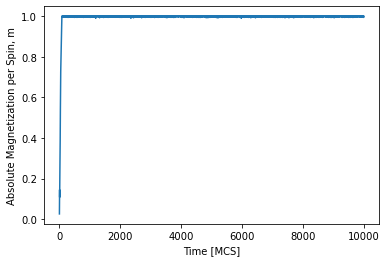

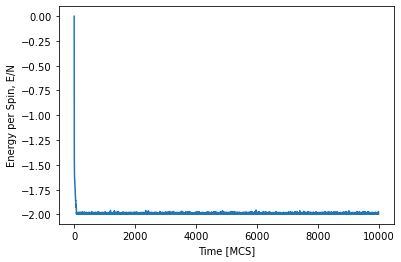

108.03378677368164


In [11]:
ti = time.time()
system1 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem1 = mcsIsingModel(system1,10**4,1,kTs[0])
plt.plot(mcsSystem1[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.show()
plt.plot(mcsSystem1[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
tf = time.time()
print(tf-ti)

**Figure 2:** The system almost instantly has all of its spins aligned. Therefore, the energy is more negative.

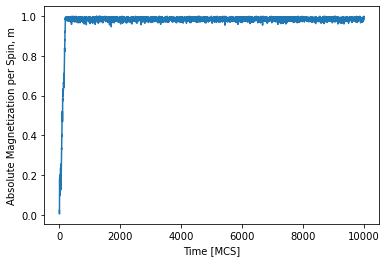

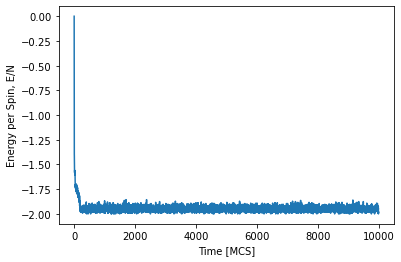

112.50759935379028


In [12]:
ti = time.time()
system2 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem2 = mcsIsingModel(system2,10**4,1,kTs[1])
plt.plot(mcsSystem2[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.show()
plt.plot(mcsSystem2[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
tf = time.time()
print(tf-ti)

**Figure 3:** The system takes a bit longer to align almost 
all of its spins. Even, we see the slight instability from the noise shown.

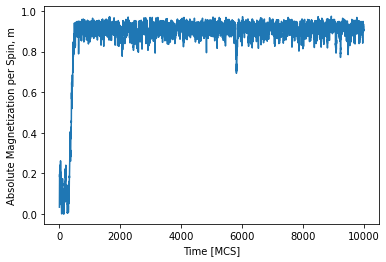

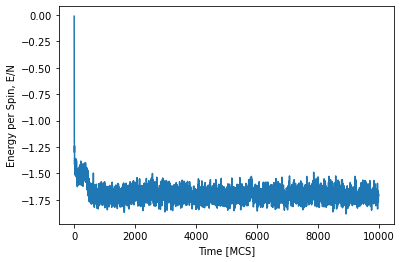

158.44973993301392


In [13]:
ti = time.time()
system3 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem3 = mcsIsingModel(system3,10**4,1,kTs[2])
plt.plot(mcsSystem3[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.show()
plt.plot(mcsSystem3[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
tf = time.time()
print(tf-ti)

**Figure 4:** The system takes longer to align most of its spins, which makes the magnetization lower and energy higher. Additionally, it's less stable.

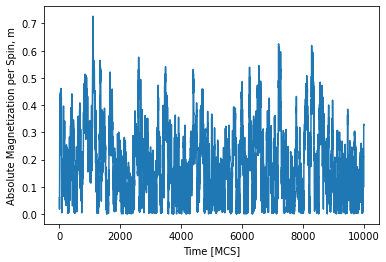

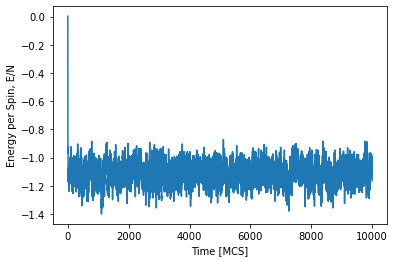

142.50021290779114


In [14]:
ti = time.time()
system4 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem4 = mcsIsingModel(system4,10**4,1,kTs[6])
plt.plot(mcsSystem4[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.show()
plt.plot(mcsSystem4[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
tf = time.time()
print(tf-ti)

**Figure 5:** The system is much less stable and does not have about half of its spins aligned.

In [15]:
ti = time.time()
system5 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem5 = mcsIsingModel(system5,10**4,1,kTs[7])
tf = time.time()
print(tf-ti)

145.51213574409485


In [16]:
ti = time.time()
system6 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem6 = mcsIsingModel(system6,10**4,1,kTs[8])
tf = time.time()
print(tf-ti)

152.8913390636444


In [17]:
# Remaining plots for part b more points are required
ti = time.time()
system7 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem7 = mcsIsingModel(system7,10**4,1,kTs[3])
tf = time.time()
print(tf-ti)

142.1416220664978


In [18]:
ti = time.time()
system8 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem8 = mcsIsingModel(system8,10**4,1,kTs[4])
tf = time.time()
print(tf-ti)

156.986670255661


In [19]:
ti = time.time()
system9 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem9 = mcsIsingModel(system9,10**4,1,kTs[5])
tf = time.time()
print(tf-ti)

186.7126293182373


### Density Plots for kT = 1.0

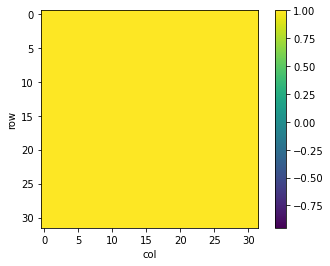

In [20]:
plt.imshow(mcsSystem1[4][2],vmin=-0.95)
plt.colorbar()
plt.xlabel('col')
plt.ylabel('row')
plt.show()

### Density Plots for kT = 1.5

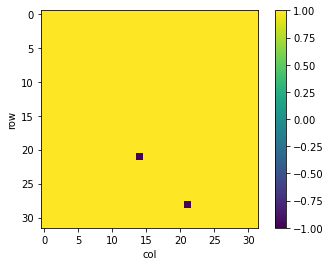

In [21]:
plt.imshow(mcsSystem2[4][2])
plt.colorbar()
plt.xlabel('col')
plt.ylabel('row')
plt.show()

### Density Plots for kT = 2.0

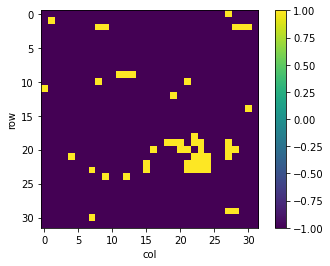

In [22]:
plt.imshow(mcsSystem3[4][2])
plt.colorbar()
plt.xlabel('col')
plt.ylabel('row')
plt.show()

### Density Plots for kT = 2.5

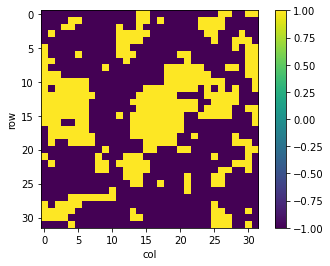

In [23]:
plt.imshow(mcsSystem4[4][2])
plt.colorbar()
plt.xlabel('col')
plt.ylabel('row')
plt.show()

**Figure 6:** These are density plots of a 32x32 lattice at different temperatures. As temperature increases, the lattice has less spins aligned.

### (Time) Average Absolute Magnetization and Energy per Spin Over Temperature

<ipython-input-72-1b99ffa81e5e>:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(kT1_1,(1 - (sinh((2*1)/kT1_1))**(-4))**(1/8),'k-')
<ipython-input-72-1b99ffa81e5e>:16: RuntimeWarning: invalid value encountered in power
  plt.plot(kT1_1,(1 - (sinh((2*1)/kT1_1))**(-4))**(1/8),'k-')


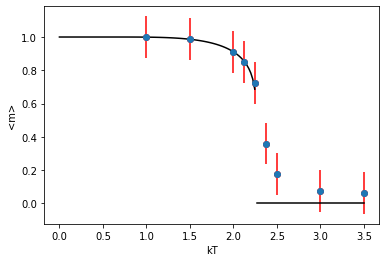

In [72]:
irt = 5000 # initial relaxation time
avemL = np.zeros(9)
avem1,avem2 = np.mean(mcsSystem1[0][irt:]),np.mean(mcsSystem2[0][irt:])
avem3,avem4 = np.mean(mcsSystem3[0][irt:]),np.mean(mcsSystem4[0][irt:])
avem5,avem6 = np.mean(mcsSystem5[0][irt:]),np.mean(mcsSystem6[0][irt:])
avem7,avem8 = np.mean(mcsSystem7[0][irt:]),np.mean(mcsSystem8[0][irt:])
avem9 = np.mean(mcsSystem9[0][irt:])
avemL[0],avemL[1] = avem1,avem2
avemL[2],avemL[6] = avem3,avem4
avemL[7],avemL[8] = avem5,avem6
avemL[3],avemL[4] = avem7,avem8
avemL[5] = avem9
avemLerr = np.std(avemL)/sqrt(len(avemL))
plt.errorbar(kTs,avemL,avemLerr,fmt='o',ecolor='red')
plt.plot(kTs,avemL,'ro')
plt.plot(kT1_1,(1 - (sinh((2*1)/kT1_1))**(-4))**(1/8),'k-')
plt.plot(kT1_2,kT1_2-kT1_2,'k-')
plt.ylabel('<m>')
plt.xlabel('kT')
plt.show()

**Figure 7:** The numerical calculations for the absolute magnetization per spin is very accurate; however, it starts branching off as the plot goes past $kT_c$.

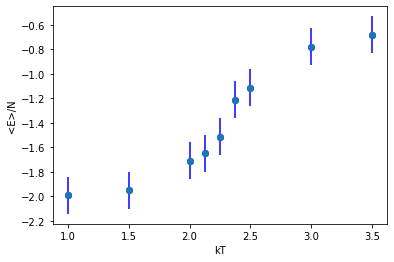

In [33]:
aveEL = np.zeros(9)
aveE1,aveE2 = np.mean(mcsSystem1[1][irt:]),np.mean(mcsSystem2[1][irt:])
aveE3,aveE4 = np.mean(mcsSystem3[1][irt:]),np.mean(mcsSystem4[1][irt:])
aveE5,aveE6 = np.mean(mcsSystem5[1][irt:]),np.mean(mcsSystem6[1][irt:])
aveE7,aveE8 = np.mean(mcsSystem7[1][irt:]),np.mean(mcsSystem8[1][irt:])
aveE9 = np.mean(mcsSystem9[1][irt:])
aveEL[0],aveEL[1] = aveE1,aveE2
aveEL[2],aveEL[6] = aveE3,aveE4
aveEL[7],aveEL[8] = aveE5,aveE6
aveEL[3],aveEL[4] = aveE7,aveE8
aveEL[5] = aveE9
aveELerr = np.std(aveEL)/sqrt(len(aveEL))
plt.errorbar(kTs,aveEL,aveELerr,fmt='o',ecolor='blue')
plt.plot(kTs,aveEL,'bo')
plt.ylabel('<E>/N')
plt.xlabel('kT')
plt.show()

**Figure 8:** We can see that the average energy per spin increases as temperature increases.

### Heat Capacity & Magnetic Susceptibility Over Temperature

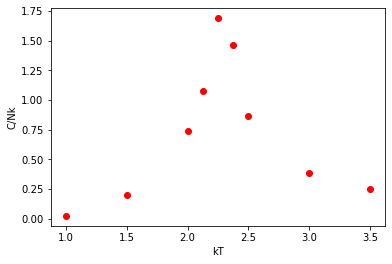

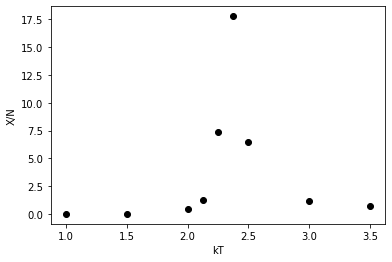

In [26]:
kTs = np.array(kTs)
aveEsqL = np.zeros(9)
avemsqL = np.zeros(9)
aveEsq1,aveEsq2 = np.mean(mcsSystem1[3][irt:]),np.mean(mcsSystem2[3][irt:])
aveEsq3,aveEsq4 = np.mean(mcsSystem3[3][irt:]),np.mean(mcsSystem4[3][irt:])
aveEsq5,aveEsq6 = np.mean(mcsSystem5[3][irt:]),np.mean(mcsSystem6[3][irt:])
aveEsq7,aveEsq8 = np.mean(mcsSystem7[3][irt:]),np.mean(mcsSystem8[3][irt:])
aveEsq9 = np.mean(mcsSystem9[3][irt:])
aveEsqL[0],aveEsqL[1] = aveEsq1,aveEsq2
aveEsqL[2],aveEsqL[6] = aveEsq3,aveEsq4
aveEsqL[7],aveEsqL[8] = aveEsq5,aveEsq6
aveEsqL[3],aveEsqL[4] = aveEsq7,aveEsq8
aveEsqL[5] = aveEsq9
avemsq1,avemsq2 = np.mean(mcsSystem1[2][irt:]),np.mean(mcsSystem2[2][irt:])
avemsq3,avemsq4 = np.mean(mcsSystem3[2][irt:]),np.mean(mcsSystem4[2][irt:])
avemsq5,avemsq6 = np.mean(mcsSystem5[2][irt:]),np.mean(mcsSystem6[2][irt:])
avemsq7,avemsq8 = np.mean(mcsSystem7[2][irt:]),np.mean(mcsSystem8[2][irt:])
avemsq9 = np.mean(mcsSystem9[2][irt:])
avemsqL[0],avemsqL[1] = avemsq1,avemsq2
avemsqL[2],avemsqL[6] = avemsq3,avemsq4
avemsqL[7],avemsqL[8] = avemsq5,avemsq6
avemsqL[3],avemsqL[4] = avemsq7,avemsq8
avemsqL[5] = avemsq9
hC = (aveEsqL - (aveEL*aveEL*(32)**4))/((32*32)*(kTs)**2)
mS = (32*32)*(avemsqL*(32)**(-4) - (avemL*avemL))/(kTs)
#print(aveEsqL)
#print(avemL*avemL)
#print(avemsqL*(32)**(-4))
plt.plot(kTs,hC,'ro')
plt.xlabel('kT')
plt.ylabel('C/Nk')
plt.show()
plt.plot(kTs,mS,'ko')
plt.xlabel('kT')
plt.ylabel('X/N')
plt.show()

**Figure 9:** The above plot is the heat capacity of the system. The bottom is the magnetic susceptibility. Both should diverge at $kT_c$, which they do. 

### Results
Without an external field, the system naturally flips the spins to align all of them since it's model of a magnetic object and it's the most energetically favorable. However, as the system approaches the critical temperature and to higher temperatures, the system becomes less stable and less spins are aligned; therefore, the absolute magnetization per spin decreases and energy per spin increases. This is all because the high temperatures cause the spins or dipoles to vibrate and move around in the system, which affects the alignment of the dipoles. Additionally, the heat capacity and magnetic susceptibility diverges and increases as it approaches to $kT_c$.

## Two-Dimensional Model: With External Magnetic Field
### Introduction
In this problem, we will be studying the 2D Ising Model with an external magnetic field--a constant and periodic field. We will see if it affects the relationship between magnetization and temperature.
$$E_{i,\text{old}}=-J\sum_{j}s_is_j -Hs_i$$
$$E_{i,\text{new}}=-J\sum_{j}(-s_i)s_j - H(-s_i) = J\sum_{j}s_is_j + Hs_i$$
$$\Delta E_i=2Js_i\left(s_{j_1}+s_{j_2}+s_{j_3}+s_{j_4}\right) + 2Hs_i = 2s_i\left[J\left(s_{j_1}+s_{j_2}+s_{j_3}+s_{j_4}\right) + H\right]$$
We will use a similar algorithm that we used for the 2nd problem; however, there will be more inputs and changes to the change in energy equation. We will use the change in energy equation to speed up calculations.

In [6]:
def mcsIsingModel2(grid,steps,J,kT,H):
    L = len(grid)
    N = L*L
    oldGrid = np.copy(grid)
    mag = np.sum(oldGrid)
    tm = np.absolute(mag) # Absolute total magnetization, M
    oldE = isingE2(oldGrid,J) - H*mag
    Es = np.zeros(steps)
    Esqs = np.zeros(steps)
    tms = np.zeros(steps) # Absolute total magnetization for each MCS
    Es[0] = oldE
    tms[0] = tm

    for k in range(1, steps):
        # Calculating adjacent spin locations for left, right, top, and bottom spins, respectively
        for spin in range(N):
            i1 = randrange(L)  # choose a row number
            j1 = randrange(L)  # choose a column number
            if (i1 >= L-1): i2,i3,i4,i5 = i1,i1,i1-1,0
            elif (i1 < 1): i2,i3,i4,i5 = i1,i1,L-1,i1+1
            else: i2,i3,i4,i5 = i1,i1,i1-1,i1+1
            if (j1 >= L-1): j2,j3,j4,j5 = j1-1,0,j1,j1
            elif (j1 < 1): j2,j3,j4,j5 = L-1,j1+1,j1,j1
            else: j2,j3,j4,j5 = j1-1,j1+1,j1,j1

            s1,s2,s3,s4,s5 = oldGrid[i1,j1],oldGrid[i2,j2],oldGrid[i3,j3],oldGrid[i4,j4],oldGrid[i5,j5]

            dE = (2*s1)*(J*(s2 + s3 + s4 + s5) + H)

            p = exp(-dE/(kT))
            if (random.rand() < p):
                oldGrid[i1,j1] = -s1
                oldE = oldE + dE
                tm = np.absolute(np.sum(oldGrid))

        Es[k] = oldE
        tms[k] = tm

    tms /= N # Absolute magnetization per spin for each MCS
    Es /= N # Energy per spin for each MCS
    
    return tms,Es

### Absolute Magnetization and Energy per Spin Over Time Plots for T = {1.0, 1.5, 2.0, 2.5} at H = 0.125

In [4]:
kTs = [1.0,1.5,2.0,2.125,2.25,2.375,2.5,3.0,3.5]
H = [0.125,0.25,0.375,0.5]
system_rows = 32
system_cols = 32

117.94200110435486
117.80455803871155
123.42800045013428
129.76996755599976
130.05244135856628
132.76898384094238
141.2214593887329
162.29619526863098
177.34580373764038


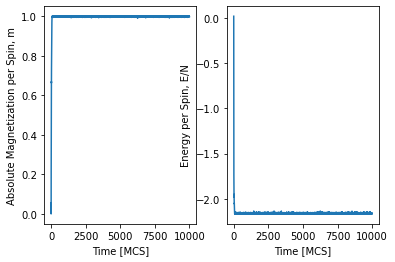

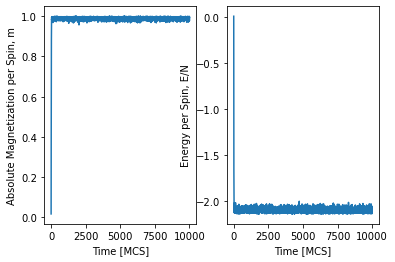

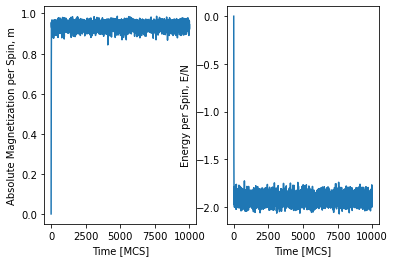

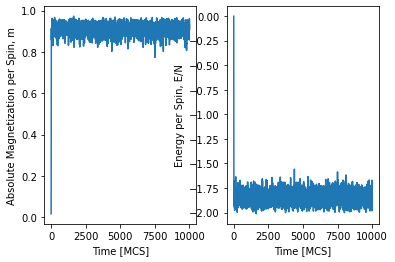

In [9]:
ti = time.time()
system10 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem10 = mcsIsingModel2(system10,10**4,1,kTs[0],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system11 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem11 = mcsIsingModel2(system11,10**4,1,kTs[1],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system12 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem12 = mcsIsingModel2(system12,10**4,1,kTs[2],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system13 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem13 = mcsIsingModel2(system13,10**4,1,kTs[3],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system14 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem14 = mcsIsingModel2(system14,10**4,1,kTs[4],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system15 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem15 = mcsIsingModel2(system15,10**4,1,kTs[5],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system16 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem16 = mcsIsingModel2(system16,10**4,1,kTs[6],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system17 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem17 = mcsIsingModel2(system17,10**4,1,kTs[7],H[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system18 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem18 = mcsIsingModel2(system18,10**4,1,kTs[8],H[0])
tf = time.time()
print(tf-ti)
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem10[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem10[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem11[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem11[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem12[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem12[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem13[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem13[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()

### Absolute Magnetization and Energy per Spin Over Time Plots for T = {1.0, 1.5, 2.0, 2.5} at H = 0.25

120.53070425987244
118.96697807312012
122.69894695281982
125.17179942131042
128.9113004207611
130.4940984249115
135.00999116897583
154.12289261817932
168.72303748130798


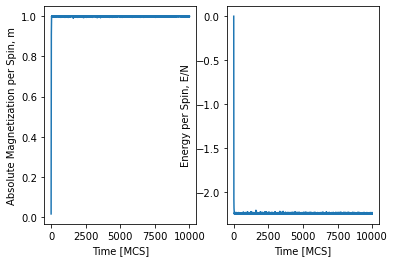

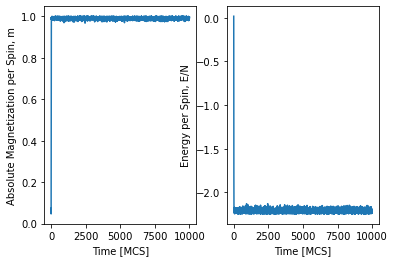

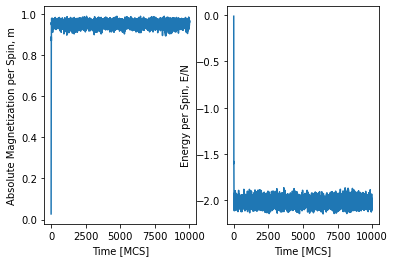

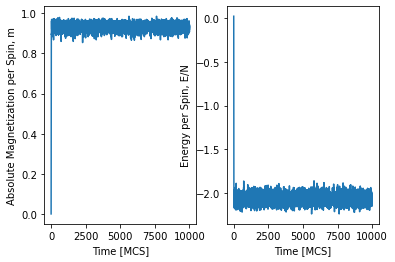

In [35]:
ti = time.time()
system19 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem19 = mcsIsingModel2(system19,10**4,1,kTs[0],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system20 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem20 = mcsIsingModel2(system20,10**4,1,kTs[1],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system21 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem21 = mcsIsingModel2(system21,10**4,1,kTs[2],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system22 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem22 = mcsIsingModel2(system22,10**4,1,kTs[3],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system23 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem23 = mcsIsingModel2(system23,10**4,1,kTs[4],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system24 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem24 = mcsIsingModel2(system24,10**4,1,kTs[5],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system25 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem25 = mcsIsingModel2(system25,10**4,1,kTs[6],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system26 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem26 = mcsIsingModel2(system26,10**4,1,kTs[7],H[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system27 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem27 = mcsIsingModel2(system27,10**4,1,kTs[8],H[1])
tf = time.time()
print(tf-ti)
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem19[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem19[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem20[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem20[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem21[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem21[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem22[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem22[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()

### Absolute Magnetization and Energy per Spin Over Time Plots for T = {1.0, 1.5, 2.0, 2.5} at H = 0.375

127.94890809059143
120.26542019844055
122.24312806129456
125.73973536491394
125.45024275779724
129.84883666038513
130.72449803352356
147.27020978927612
162.28107070922852


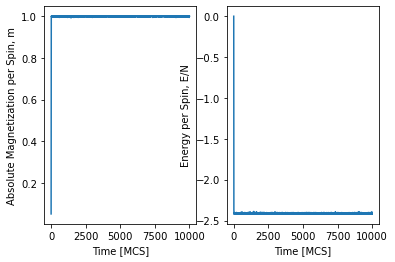

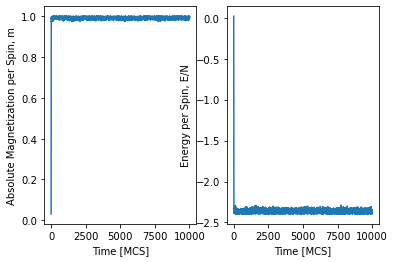

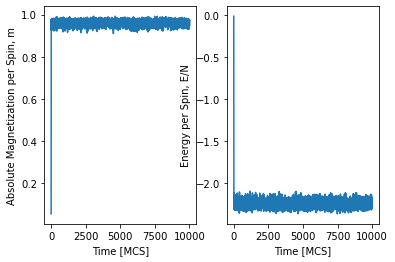

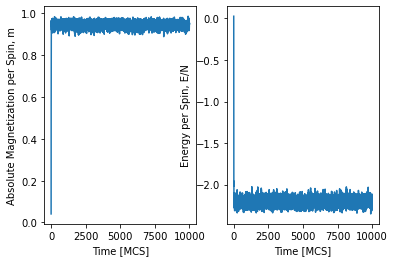

In [40]:
ti = time.time()
system28 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem28 = mcsIsingModel2(system28,10**4,1,kTs[0],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system29 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem29 = mcsIsingModel2(system29,10**4,1,kTs[1],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system30 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem30 = mcsIsingModel2(system30,10**4,1,kTs[2],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system31 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem31 = mcsIsingModel2(system31,10**4,1,kTs[3],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system32 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem32 = mcsIsingModel2(system32,10**4,1,kTs[4],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system33 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem33 = mcsIsingModel2(system33,10**4,1,kTs[5],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system34 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem34 = mcsIsingModel2(system34,10**4,1,kTs[6],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system35 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem35 = mcsIsingModel2(system35,10**4,1,kTs[7],H[2])
tf = time.time()
print(tf-ti)
ti = time.time()
system36 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem36 = mcsIsingModel2(system36,10**4,1,kTs[8],H[2])
tf = time.time()
print(tf-ti)
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem28[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem28[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem29[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem29[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem30[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem30[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem31[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem31[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()

### Absolute Magnetization and Energy per Spin Over Time Plots for T = {1.0, 1.5, 2.0, 2.5} at H = 0.50

121.29271006584167
123.58450078964233
128.88041639328003
132.3381540775299
128.71287178993225
131.10357975959778
131.2221188545227
141.47712421417236
153.8536455631256


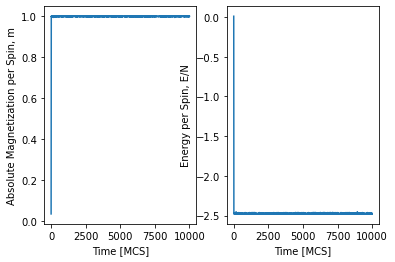

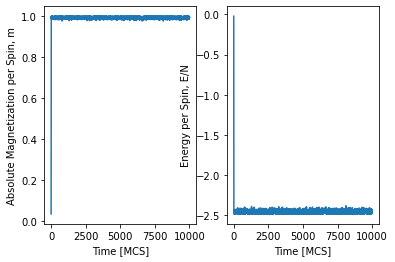

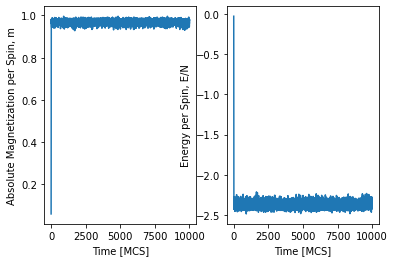

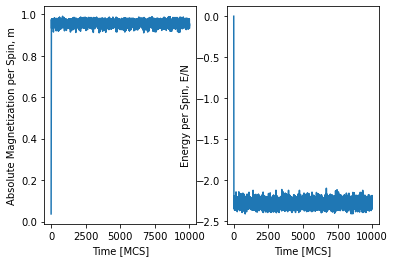

In [41]:
ti = time.time()
system37 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem37 = mcsIsingModel2(system37,10**4,1,kTs[0],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system38 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem38 = mcsIsingModel2(system38,10**4,1,kTs[1],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system39 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem39 = mcsIsingModel2(system39,10**4,1,kTs[2],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system40 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem40 = mcsIsingModel2(system40,10**4,1,kTs[3],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system41 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem41 = mcsIsingModel2(system41,10**4,1,kTs[4],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system42 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem42 = mcsIsingModel2(system42,10**4,1,kTs[5],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system43 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem43 = mcsIsingModel2(system43,10**4,1,kTs[6],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system44 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem44 = mcsIsingModel2(system44,10**4,1,kTs[7],H[3])
tf = time.time()
print(tf-ti)
ti = time.time()
system45 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem45 = mcsIsingModel2(system45,10**4,1,kTs[8],H[3])
tf = time.time()
print(tf-ti)
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem37[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem37[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem38[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem38[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem39[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem39[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()
plt.figure()
plt.subplot(1,2,1)
plt.plot(mcsSystem40[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Absolute Magnetization per Spin, m")
plt.subplot(1,2,2)
plt.plot(mcsSystem40[1])
plt.xlabel("Time [MCS]")
plt.ylabel("Energy per Spin, E/N")
plt.show()

**Figure 10:** We see similar trends to the Zero External Magnetic Field scenario, with less stability as temperature increases, for every H.

### (Time) Average Absolute Magnetization and Energy per Spin Over Temperature

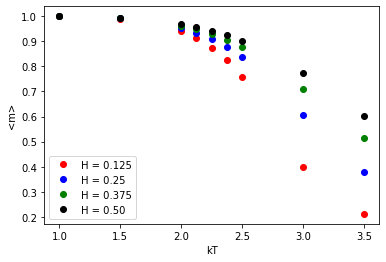

In [45]:
irt = 5000 # initial relaxation time
avemL1 = np.zeros(9)
avemL2 = np.zeros(9)
avemL3 = np.zeros(9)
avemL4 = np.zeros(9)
avem1_1,avem2_1 = np.mean(mcsSystem10[0][irt:]),np.mean(mcsSystem11[0][irt:])
avem3_1,avem4_1 = np.mean(mcsSystem12[0][irt:]),np.mean(mcsSystem13[0][irt:])
avem5_1,avem6_1 = np.mean(mcsSystem14[0][irt:]),np.mean(mcsSystem15[0][irt:])
avem7_1,avem8_1 = np.mean(mcsSystem16[0][irt:]),np.mean(mcsSystem17[0][irt:])
avem9_1 = np.mean(mcsSystem18[0][irt:])
avem1_2,avem2_2 = np.mean(mcsSystem19[0][irt:]),np.mean(mcsSystem20[0][irt:])
avem3_2,avem4_2 = np.mean(mcsSystem21[0][irt:]),np.mean(mcsSystem22[0][irt:])
avem5_2,avem6_2 = np.mean(mcsSystem23[0][irt:]),np.mean(mcsSystem24[0][irt:])
avem7_2,avem8_2 = np.mean(mcsSystem25[0][irt:]),np.mean(mcsSystem26[0][irt:])
avem9_2 = np.mean(mcsSystem27[0][irt:])
avem1_3,avem2_3 = np.mean(mcsSystem28[0][irt:]),np.mean(mcsSystem29[0][irt:])
avem3_3,avem4_3 = np.mean(mcsSystem30[0][irt:]),np.mean(mcsSystem31[0][irt:])
avem5_3,avem6_3 = np.mean(mcsSystem32[0][irt:]),np.mean(mcsSystem33[0][irt:])
avem7_3,avem8_3 = np.mean(mcsSystem34[0][irt:]),np.mean(mcsSystem35[0][irt:])
avem9_3 = np.mean(mcsSystem36[0][irt:])
avem1_4,avem2_4 = np.mean(mcsSystem37[0][irt:]),np.mean(mcsSystem38[0][irt:])
avem3_4,avem4_4 = np.mean(mcsSystem39[0][irt:]),np.mean(mcsSystem40[0][irt:])
avem5_4,avem6_4 = np.mean(mcsSystem41[0][irt:]),np.mean(mcsSystem42[0][irt:])
avem7_4,avem8_4 = np.mean(mcsSystem43[0][irt:]),np.mean(mcsSystem44[0][irt:])
avem9_4 = np.mean(mcsSystem45[0][irt:])
avemL1[0],avemL1[1] = avem1_1,avem2_1
avemL1[2],avemL1[3] = avem3_1,avem4_1
avemL1[4],avemL1[5] = avem5_1,avem6_1
avemL1[6],avemL1[7] = avem7_1,avem8_1
avemL1[8] = avem9_1
avemL2[0],avemL2[1] = avem1_2,avem2_2
avemL2[2],avemL2[3] = avem3_2,avem4_2
avemL2[4],avemL2[5] = avem5_2,avem6_2
avemL2[6],avemL2[7] = avem7_2,avem8_2
avemL2[8] = avem9_2
avemL3[0],avemL3[1] = avem1_3,avem2_3
avemL3[2],avemL3[3] = avem3_3,avem4_3
avemL3[4],avemL3[5] = avem5_3,avem6_3
avemL3[6],avemL3[7] = avem7_3,avem8_3
avemL3[8] = avem9_3
avemL4[0],avemL4[1] = avem1_4,avem2_4
avemL4[2],avemL4[3] = avem3_4,avem4_4
avemL4[4],avemL4[5] = avem5_4,avem6_4
avemL4[6],avemL4[7] = avem7_4,avem8_4
avemL4[8] = avem9_4
plt.plot(kTs,avemL1,'ro',label = 'H = 0.125')
plt.plot(kTs,avemL2,'bo',label = 'H = 0.25')
plt.plot(kTs,avemL3,'go',label = 'H = 0.375')
plt.plot(kTs,avemL4,'ko',label = 'H = 0.50')
plt.legend()
plt.ylabel('<m>')
plt.xlabel('kT')
plt.show()

**Figure 11:** Both the zero and non-zero external magnetic field systems are similar before they hit $kT_c$. However, higher strength magnetic fields branch off at lower temperatures, decreasing at a lower rate.

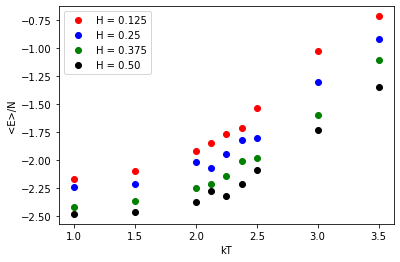

In [47]:
aveEL1 = np.zeros(9)
aveEL2 = np.zeros(9)
aveEL3 = np.zeros(9)
aveEL4 = np.zeros(9)
aveE1_1,aveE2_1 = np.mean(mcsSystem10[1][irt:]),np.mean(mcsSystem11[1][irt:])
aveE3_1,aveE4_1 = np.mean(mcsSystem12[1][irt:]),np.mean(mcsSystem13[1][irt:])
aveE5_1,aveE6_1 = np.mean(mcsSystem14[1][irt:]),np.mean(mcsSystem15[1][irt:])
aveE7_1,aveE8_1 = np.mean(mcsSystem16[1][irt:]),np.mean(mcsSystem17[1][irt:])
aveE9_1 = np.mean(mcsSystem18[1][irt:])
aveE1_2,aveE2_2 = np.mean(mcsSystem19[1][irt:]),np.mean(mcsSystem20[1][irt:])
aveE3_2,aveE4_2 = np.mean(mcsSystem21[1][irt:]),np.mean(mcsSystem22[1][irt:])
aveE5_2,aveE6_2 = np.mean(mcsSystem23[1][irt:]),np.mean(mcsSystem24[1][irt:])
aveE7_2,aveE8_2 = np.mean(mcsSystem25[1][irt:]),np.mean(mcsSystem26[1][irt:])
aveE9_2 = np.mean(mcsSystem27[1][irt:])
aveE1_3,aveE2_3 = np.mean(mcsSystem28[1][irt:]),np.mean(mcsSystem29[1][irt:])
aveE3_3,aveE4_3 = np.mean(mcsSystem30[1][irt:]),np.mean(mcsSystem31[1][irt:])
aveE5_3,aveE6_3 = np.mean(mcsSystem32[1][irt:]),np.mean(mcsSystem33[1][irt:])
aveE7_3,aveE8_3 = np.mean(mcsSystem34[1][irt:]),np.mean(mcsSystem35[1][irt:])
aveE9_3 = np.mean(mcsSystem36[1][irt:])
aveE1_4,aveE2_4 = np.mean(mcsSystem37[1][irt:]),np.mean(mcsSystem38[1][irt:])
aveE3_4,aveE4_4 = np.mean(mcsSystem39[1][irt:]),np.mean(mcsSystem40[1][irt:])
aveE5_4,aveE6_4 = np.mean(mcsSystem41[1][irt:]),np.mean(mcsSystem42[1][irt:])
aveE7_4,aveE8_4 = np.mean(mcsSystem43[1][irt:]),np.mean(mcsSystem44[1][irt:])
aveE9_4 = np.mean(mcsSystem45[1][irt:])
aveEL1[0],aveEL1[1] = aveE1_1,aveE2_1
aveEL1[2],aveEL1[3] = aveE3_1,aveE4_1
aveEL1[4],aveEL1[5] = aveE5_1,aveE6_1
aveEL1[6],aveEL1[7] = aveE7_1,aveE8_1
aveEL1[8] = aveE9_1
aveEL2[0],aveEL2[1] = aveE1_2,aveE2_2
aveEL2[2],aveEL2[3] = aveE3_2,aveE4_2
aveEL2[4],aveEL2[5] = aveE5_2,aveE6_2
aveEL2[6],aveEL2[7] = aveE7_2,aveE8_2
aveEL2[8] = aveE9_2
aveEL3[0],aveEL3[1] = aveE1_3,aveE2_3
aveEL3[2],aveEL3[3] = aveE3_3,aveE4_3
aveEL3[4],aveEL3[5] = aveE5_3,aveE6_3
aveEL3[6],aveEL3[7] = aveE7_3,aveE8_3
aveEL3[8] = aveE9_3
aveEL4[0],aveEL4[1] = aveE1_4,aveE2_4
aveEL4[2],aveEL4[3] = aveE3_4,aveE4_4
aveEL4[4],aveEL4[5] = aveE5_4,aveE6_4
aveEL4[6],aveEL4[7] = aveE7_4,aveE8_4
aveEL4[8] = aveE9_4
plt.plot(kTs,aveEL1,'ro',label = 'H = 0.125')
plt.plot(kTs,aveEL2,'bo',label = 'H = 0.25')
plt.plot(kTs,aveEL3,'go',label = 'H = 0.375')
plt.plot(kTs,aveEL4,'ko',label = 'H = 0.50')
plt.legend()
plt.ylabel('<E>/N')
plt.xlabel('kT')
plt.show()

**Figure 12:** Both the zero and non-zero external magnetic field systems increase to higher energies, but non-zero external magnetic field systems are lower in energy, in general.

In [49]:
def mcsIsingModel3(grid,steps,J,kT,H0,P_mcs):
    w_mcs = (2*pi)/P_mcs
    L = len(grid)
    N = L*L
    oldGrid = np.copy(grid)
    H = 0 # External Field, H: H(t=0) = H_0 * sin(0) = 0
    tm = np.sum(oldGrid) # Total magnetization, M
    Hs = np.zeros(steps)
    tms = np.zeros(steps) # Absolute total magnetization for each MCS
    tms[0] = tm
    Hs[0] = H
    for k in range(1, steps):
        # Calculating adjacent spin locations for left, right, top, and bottom spins, respectively
        H = H0 * sin(w_mcs*k)
        for spin in range(N):
            i1 = randrange(L)  # choose a row number
            j1 = randrange(L)  # choose a column number
            if (i1 >= L-1): i2,i3,i4,i5 = i1,i1,i1-1,0
            elif (i1 < 1): i2,i3,i4,i5 = i1,i1,L-1,i1+1
            else: i2,i3,i4,i5 = i1,i1,i1-1,i1+1
            if (j1 >= L-1): j2,j3,j4,j5 = j1-1,0,j1,j1
            elif (j1 < 1): j2,j3,j4,j5 = L-1,j1+1,j1,j1
            else: j2,j3,j4,j5 = j1-1,j1+1,j1,j1

            s1,s2,s3,s4,s5 = oldGrid[i1,j1],oldGrid[i2,j2],oldGrid[i3,j3],oldGrid[i4,j4],oldGrid[i5,j5]
            
            dE = (2*s1)*(J*(s2 + s3 + s4 + s5) + H)

            p = exp(-dE/(kT))
            if (random.rand() < p):
                oldGrid[i1,j1] = -s1
                tm = np.sum(oldGrid)
        Hs[k] = H
        tms[k] = tm

    tms /= N # Absolute magnetization per spin for each MCS
    
    return tms,Hs

### Total Magnetization and External Field Strength Over Time Plot for P = 100 and H0 = 1 at T = {1.0, 2.0, 3.0}

In [50]:
kTs3c = [1.0,1.5,2.0,2.5,3.0,3.5]
system_rows,system_cols = 32,32
H0s = [1,5]
Ps = [100,500]

123.30442333221436
126.91867566108704
130.59792947769165
135.84775018692017
141.58067274093628
157.2736210823059


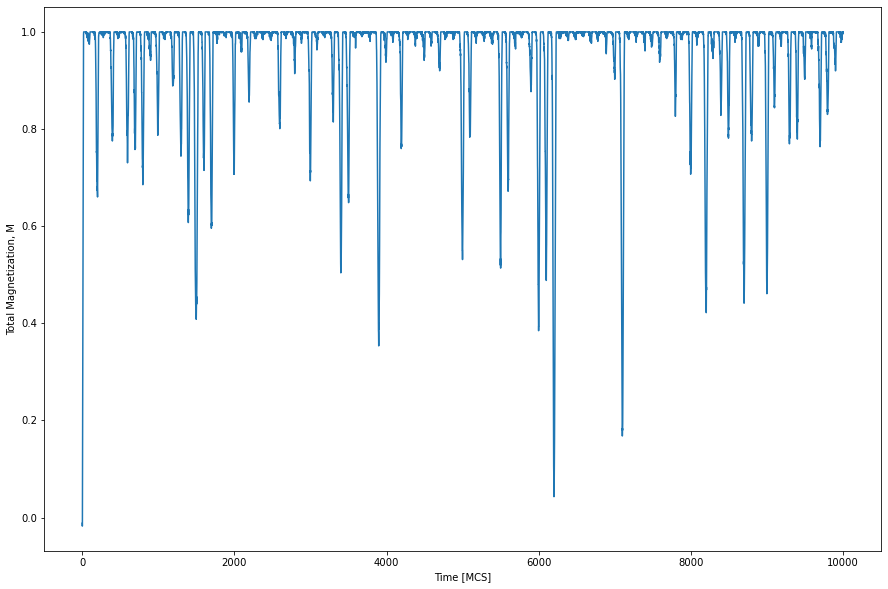

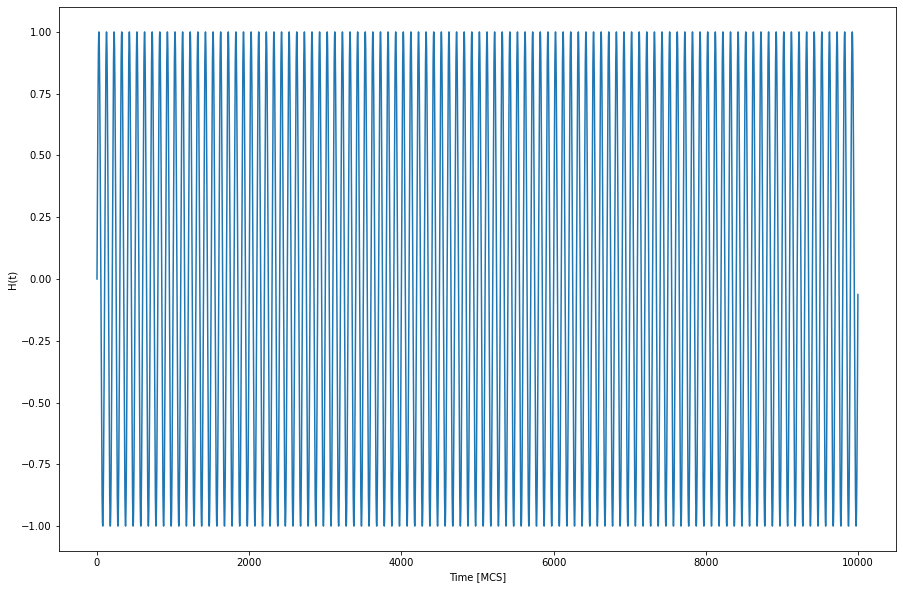

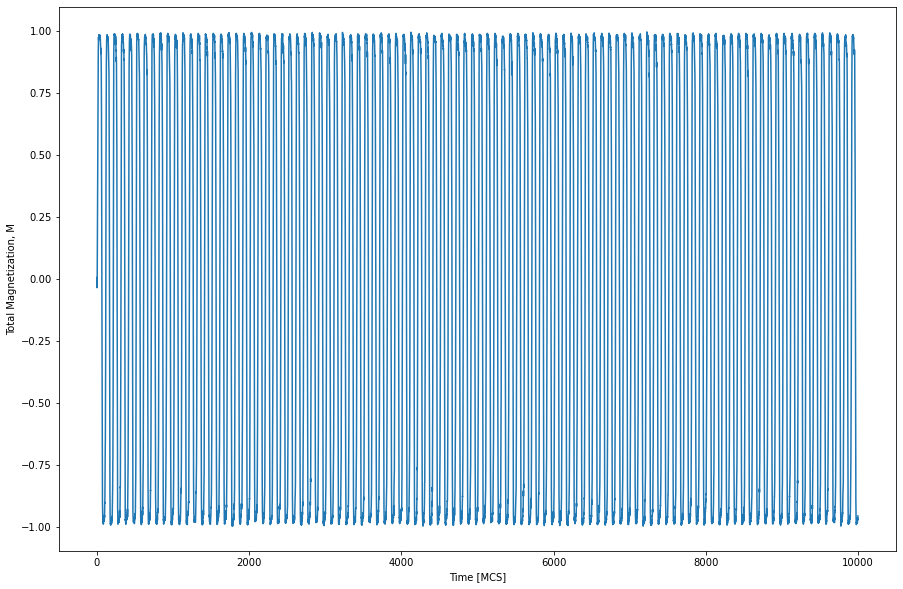

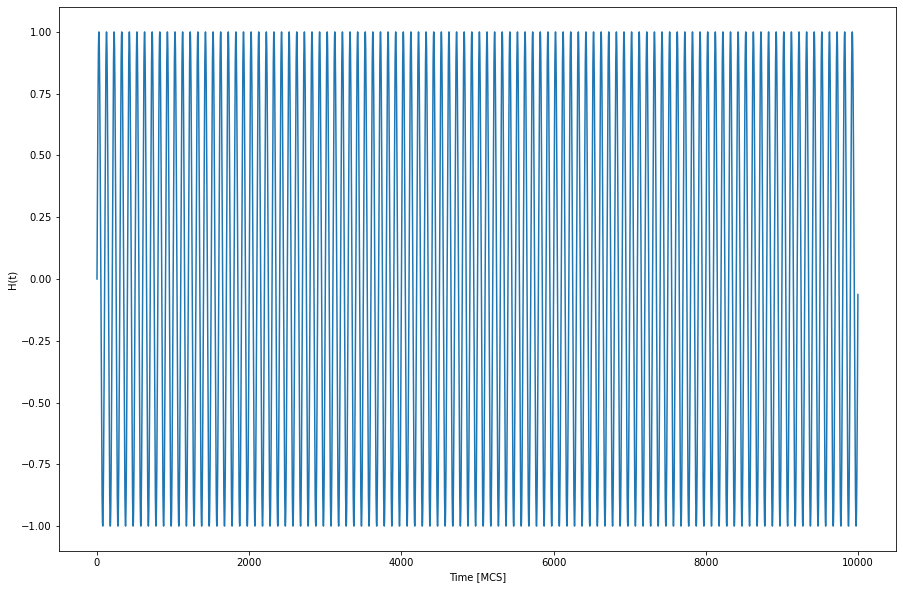

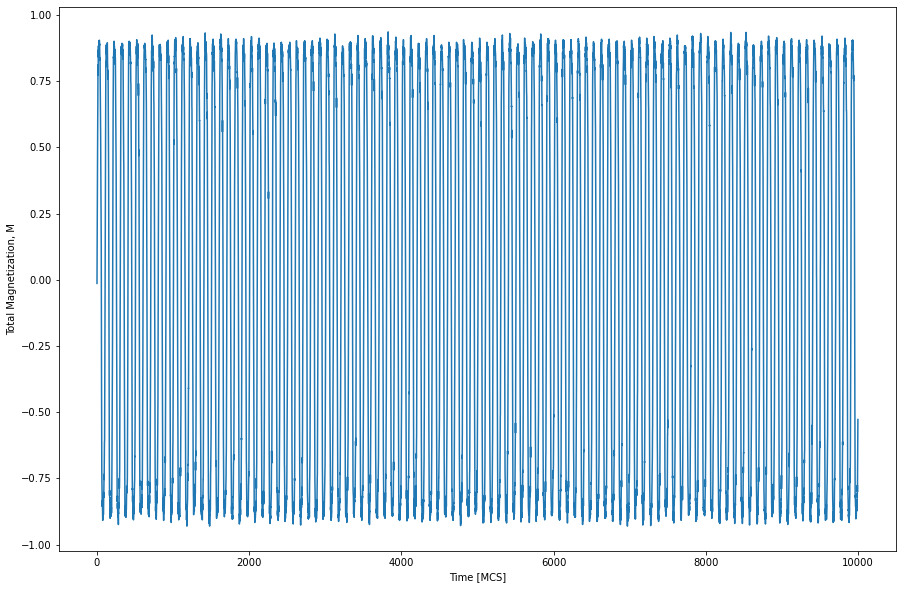

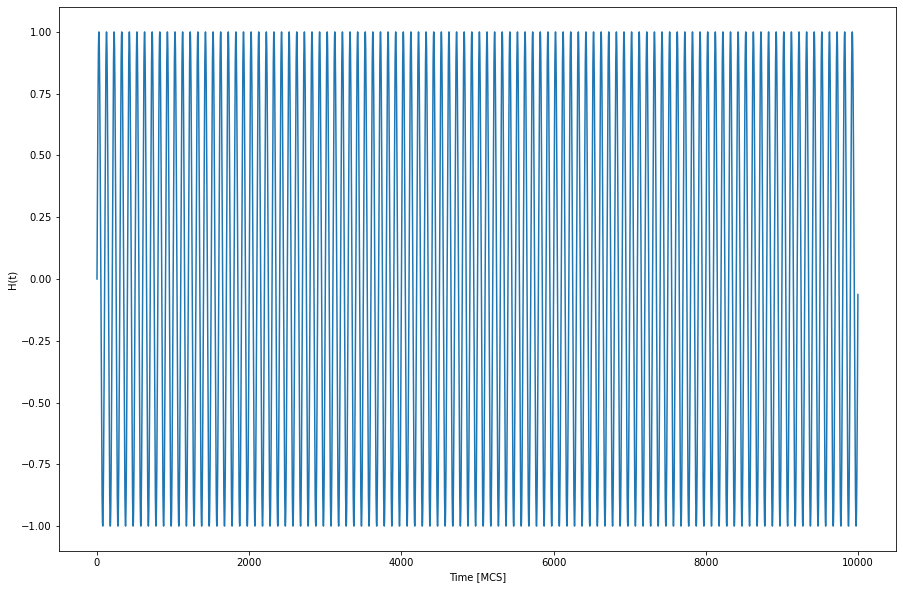

In [53]:
ti = time.time()
system46 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem46 = mcsIsingModel3(system46,10**4,1,kTs3c[0],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system47 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem47 = mcsIsingModel3(system47,10**4,1,kTs3c[1],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system48 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem48 = mcsIsingModel3(system48,10**4,1,kTs3c[2],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system49 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem49 = mcsIsingModel3(system49,10**4,1,kTs3c[3],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system50 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem50 = mcsIsingModel3(system50,10**4,1,kTs3c[4],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system51 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem51 = mcsIsingModel3(system51,10**4,1,kTs3c[5],H0s[0],Ps[0])
tf = time.time()
print(tf-ti)
plt.figure(figsize=(15,10))
plt.plot(mcsSystem46[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem46[1])
plt.xlabel("Time [MCS]")
plt.ylabel("H(t)")
plt.show()

plt.figure(figsize=(15,10))
plt.plot(mcsSystem48[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem48[1])
plt.xlabel("Time [MCS]")
plt.ylabel("H(t)")
plt.show()

plt.figure(figsize=(15,10))
plt.plot(mcsSystem50[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem50[1])
plt.xlabel("Time [MCS]")
plt.ylabel("H(t)")
plt.show()

### Total Magnetization and External Field Strength Over Time Plot for P = 500 and H0 = 1 at T = {1.0, 2.0, 3.0}

124.39538192749023
131.70459270477295
172.26932334899902
225.24005651474
207.80442070960999
202.54729342460632


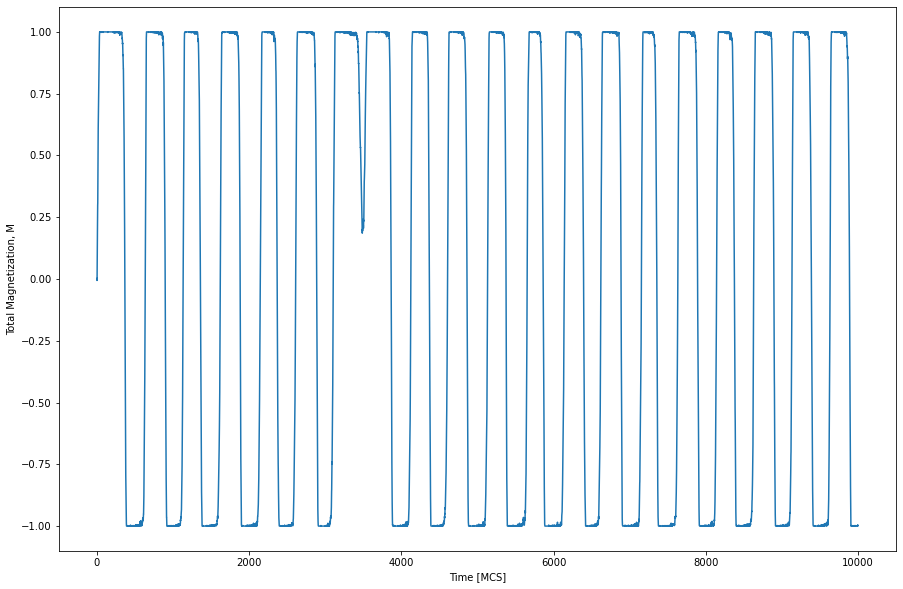

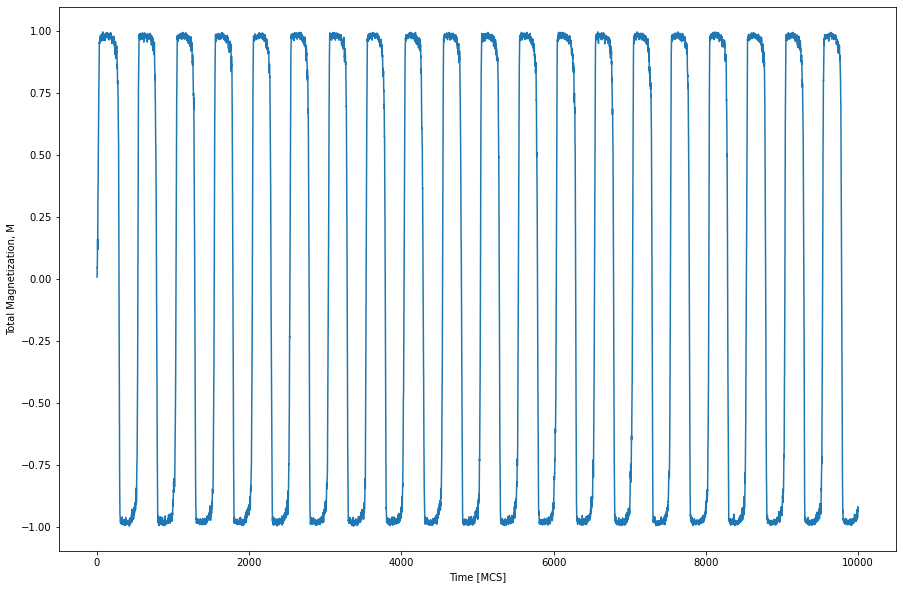

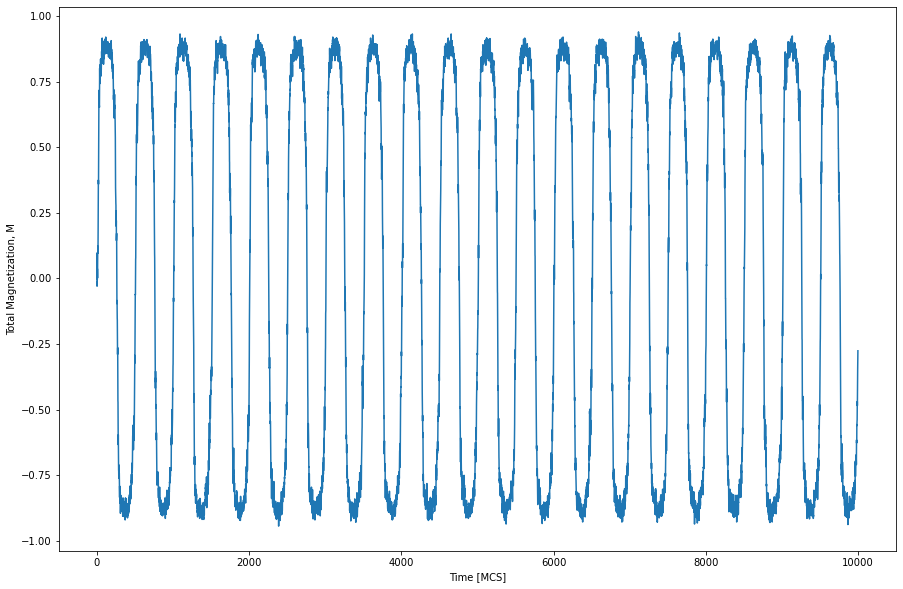

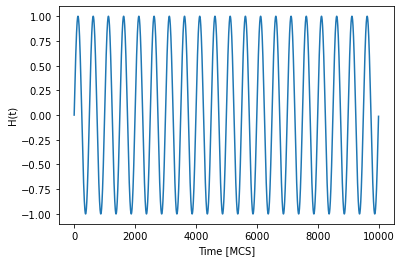

In [54]:
ti = time.time()
system52 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem52 = mcsIsingModel3(system52,10**4,1,kTs3c[0],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system53 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem53 = mcsIsingModel3(system53,10**4,1,kTs3c[1],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system54 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem54 = mcsIsingModel3(system54,10**4,1,kTs3c[2],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system55 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem55 = mcsIsingModel3(system55,10**4,1,kTs3c[3],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system56 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem56 = mcsIsingModel3(system56,10**4,1,kTs3c[4],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
ti = time.time()
system57 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem57 = mcsIsingModel3(system57,10**4,1,kTs3c[5],H0s[0],Ps[1])
tf = time.time()
print(tf-ti)
plt.figure(figsize=(15,10))
plt.plot(mcsSystem52[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem54[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem56[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.plot(mcsSystem56[1])
plt.xlabel("Time [MCS]")
plt.ylabel("H(t)")
plt.show()

### Total Magnetization and External Field Strength Over Time Plot for P = 100 and H0 = 0.5 at T = {1.0, 2.0, 3.0}

127.52227759361267
133.25067281723022
136.06816172599792
146.17717456817627
153.66733765602112
176.16004514694214


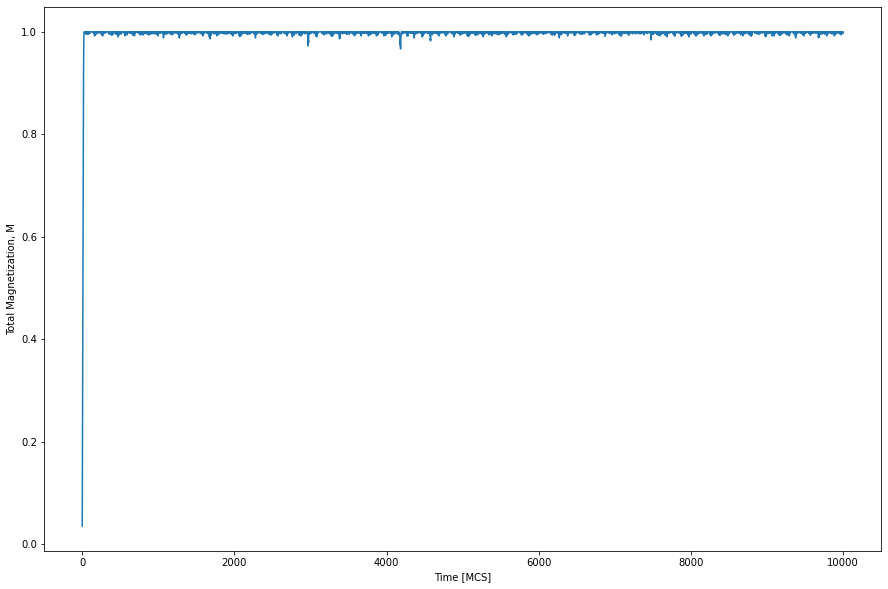

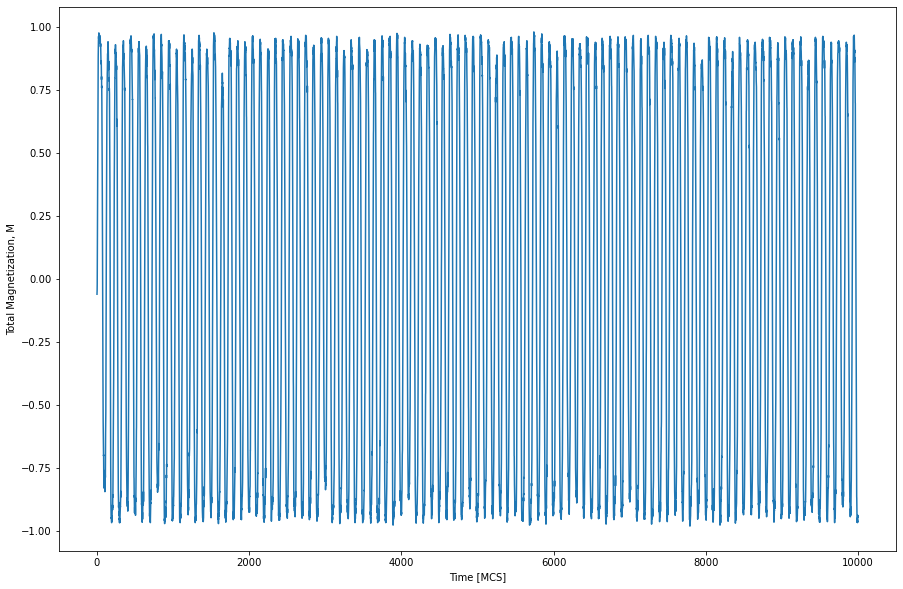

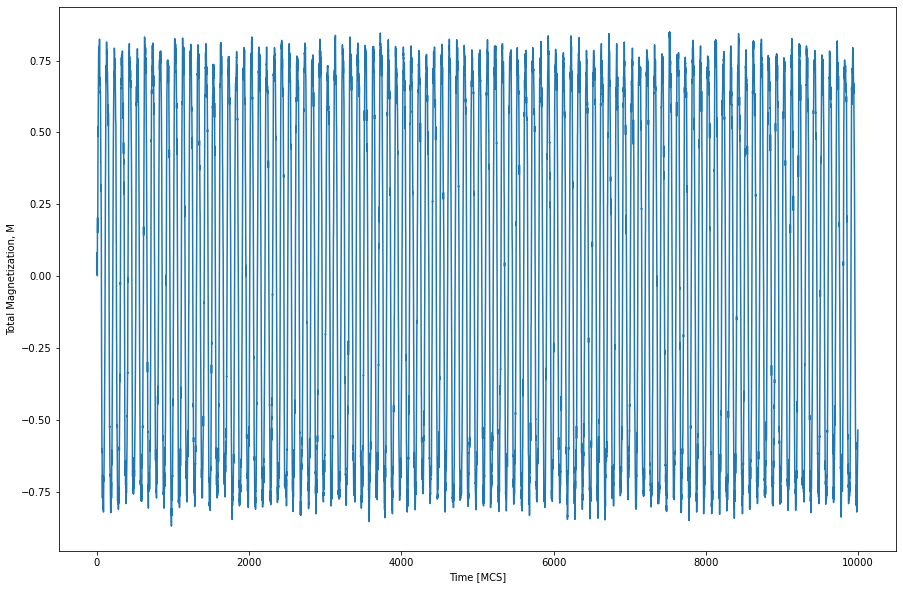

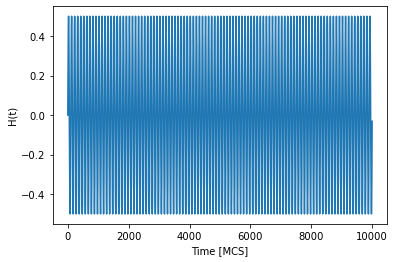

In [55]:
ti = time.time()
system58 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem58 = mcsIsingModel3(system58,10**4,1,kTs3c[0],0.5,Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system59 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem59 = mcsIsingModel3(system59,10**4,1,kTs3c[1],0.5,Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system60 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem60 = mcsIsingModel3(system60,10**4,1,kTs3c[2],0.5,Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system61 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem61 = mcsIsingModel3(system61,10**4,1,kTs3c[3],0.5,Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system62 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem62 = mcsIsingModel3(system62,10**4,1,kTs3c[4],0.5,Ps[0])
tf = time.time()
print(tf-ti)
ti = time.time()
system63 = 2*random.randint(0,2,[system_rows,system_cols]) - 1
mcsSystem63 = mcsIsingModel3(system63,10**4,1,kTs3c[5],0.5,Ps[0])
tf = time.time()
print(tf-ti)
plt.figure(figsize=(15,10))
plt.plot(mcsSystem58[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem60[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.figure(figsize=(15,10))
plt.plot(mcsSystem62[0])
plt.xlabel("Time [MCS]")
plt.ylabel("Total Magnetization, M")
plt.show()
plt.plot(mcsSystem62[1])
plt.xlabel("Time [MCS]")
plt.ylabel("H(t)")
plt.show()

**Figure 13:** As temperature increases, the total magnetization starts to align with the strength of the external magnetic field. For any change of period and amplitude.

### (Time) Average Total Magnetization Over Temperature

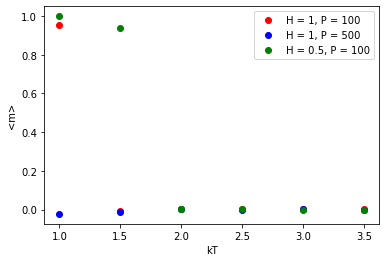

In [61]:
irt = 5000 # initial relaxation time
avemL5 = np.zeros(6)
avemL6 = np.zeros(6)
avemL7 = np.zeros(6)

avem1_5,avem2_5 = np.mean(mcsSystem46[0][irt:]),np.mean(mcsSystem47[0][irt:])
avem3_5,avem4_5 = np.mean(mcsSystem48[0][irt:]),np.mean(mcsSystem49[0][irt:])
avem5_5,avem6_5 = np.mean(mcsSystem50[0][irt:]),np.mean(mcsSystem51[0][irt:])

avem1_6,avem2_6 = np.mean(mcsSystem52[0][irt:]),np.mean(mcsSystem53[0][irt:])
avem3_6,avem4_6 = np.mean(mcsSystem54[0][irt:]),np.mean(mcsSystem55[0][irt:])
avem5_6,avem6_6 = np.mean(mcsSystem56[0][irt:]),np.mean(mcsSystem57[0][irt:])

avem1_7,avem2_7 = np.mean(mcsSystem58[0][irt:]),np.mean(mcsSystem59[0][irt:])
avem3_7,avem4_7 = np.mean(mcsSystem60[0][irt:]),np.mean(mcsSystem61[0][irt:])
avem5_7,avem6_7 = np.mean(mcsSystem62[0][irt:]),np.mean(mcsSystem63[0][irt:])

avemL5[0],avemL5[1] = avem1_5,avem2_5
avemL5[2],avemL5[3] = avem3_5,avem4_5
avemL5[4],avemL5[5] = avem5_5,avem6_5

avemL6[0],avemL6[1] = avem1_6,avem2_6
avemL6[2],avemL6[3] = avem3_6,avem4_6
avemL6[4],avemL6[5] = avem5_6,avem6_6

avemL7[0],avemL7[1] = avem1_7,avem2_7
avemL7[2],avemL7[3] = avem3_7,avem4_7
avemL7[4],avemL7[5] = avem5_7,avem6_7

plt.plot(kTs3c,avemL5,'ro',label = 'H = 1, P = 100')
plt.plot(kTs3c,avemL6,'bo',label = 'H = 1, P = 500')
plt.plot(kTs3c,avemL7,'go',label = 'H = 0.5, P = 100')
plt.legend()
plt.ylabel('<m>')
plt.xlabel('kT')
plt.show()

**Figure 14:** We see that the periodic external magnetic fields for any frequency or strength is the same after $kT_c$, at m=0. The magnetization per spin is higher for the low strength field and lower for the high frequency field.

### Results
There's considerable changes with the inclusion of a external magnetic field. A constant external magnetic field decreases the energy and increases the magnetization of the system, compared to the zero external magnetic field system. The changes in temperature also have similar effect in this scenario. This should be because the external magnetic field is influencing the spins to align to specific direction as well. However, for a periodic external magnetic field, the sign of the magnetic field strength is changing. We've seen that the magnetization of the system starts to take the form of the magnetic field strength. This is because the external magnetic field is making the system's spins flip constantly while the system itself is trying to stabilize into a state. Because higher temperatures and frequencies for the external magnetic field make the system's magnetization take form of the external magnetic field strength, the averege magnetization will be zero since the average value of a sine wave is zero.